### **Imports, Constants and Configurations:**

In [1]:
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Constants
from scripts.configs import DIS_CMAP, SET_PALETTE
from scripts.configs import CON_CMAP, DIV_CMAP
from scripts.configs import NON_STR_COLS, CREW_COLS
from scripts.configs import NON_GENRECREW_COLS, GENRE_COLS

In [2]:
warnings.filterwarnings('ignore')
SET_PALETTE()

### **Loading Data:**

In [3]:
movie_df = pd.read_csv("./data/movies_data.csv").rename(columns={'Unnamed: 0': 'ID'})

movie_df['original_language'] = movie_df['original_language'].astype('category')
movie_df['status'] = movie_df['status'].astype('category')
movie_df['actor_name_1'] = movie_df['actor_name_1'].astype('category')
movie_df['actor_name_2'] = movie_df['actor_name_2'].astype('category')
movie_df['actor_name_3'] = movie_df['actor_name_3'].astype('category')
movie_df['actor_name_4'] = movie_df['actor_name_4'].astype('category')
movie_df['actor_name_5'] = movie_df['actor_name_5'].astype('category')
movie_df['production_company_name'] = movie_df['production_company_name'].astype('category')

movie_df['revenue_millions'] = movie_df['revenue'] / 1.0e6
movie_df['budget_millions'] = movie_df['budget'] / 1.0e6
movie_df['binned_profit'] = pd.cut(movie_df['profit_rate'], bins=30, labels=False)


movie_df

,ID,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,...,actor_5_code,production_company_code,year,month,day,binned_revenue,profit_rate,revenue_millions,budget_millions,binned_profit
0,0,Four Rooms,4000000,"[{'id': 612, 'name': 'hotel'}, {'id': 613, 'na...",en,22.876230,1995-12-09,4300000,98.0,Released,...,1988,765,1995,12,9,0,1.075000,4.300000,4.0000,0
1,1,American Beauty,15000000,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...",en,80.878605,1999-09-15,356296601,122.0,Released,...,2092,341,1999,9,15,16,23.753107,356.296601,15.0000,7
2,2,Dancer in the Dark,12800000,"[{'id': 30, 'name': 'individual'}, {'id': 246,...",en,22.022228,2000-05-17,40031879,140.0,Released,...,1504,430,2000,5,17,1,3.127491,40.031879,12.8000,0
3,3,The Fifth Element,90000000,"[{'id': 402, 'name': 'clone'}, {'id': 444, 'na...",en,109.528572,1997-05-07,263920180,126.0,Released,...,541,254,1997,5,7,12,2.932446,263.920180,90.0000,0
4,4,Metropolis,92620000,"[{'id': 312, 'name': 'man vs machine'}, {'id':...",de,32.351527,1927-01-10,650422,153.0,Released,...,1035,868,1927,1,10,0,0.007022,0.650422,92.6200,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4515,4515,Restoration,0,[],en,2.525569,2016-05-03,0,90.0,Released,...,0,0,2016,5,3,0,0.000000,0.000000,0.0000,0
4516,4516,Operation Chromite,0,"[{'id': 10586, 'name': 'korea'}, {'id': 229851...",ko,6.116436,2016-07-27,0,110.0,Released,...,1649,1098,2016,7,27,0,0.000000,0.000000,0.0000,0
4517,4517,Perfect Cowboy,200,[],en,0.050978,2014-07-13,0,109.0,Released,...,0,0,2014,7,13,0,0.000000,0.000000,0.0002,0
4518,4518,Puss in Boots,130000000,"[{'id': 4414, 'name': 'adventure'}, {'id': 618...",en,20.678787,2011-10-28,554987477,90.0,Released,...,139,339,2011,10,28,25,4.269134,554.987477,130.0000,1


In [4]:
movie_df.columns

Index(['ID', 'title', 'budget', 'keywords', 'original_language', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'vote_average',
       'vote_count', 'actor_name_1', 'actor_name_2', 'actor_name_3',
       'actor_name_4', 'actor_name_5', 'production_company_name', 'Action',
       'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western',
       'language_code', 'status_code', 'actor_1_code', 'actor_2_code',
       'actor_3_code', 'actor_4_code', 'actor_5_code',
       'production_company_code', 'year', 'month', 'day', 'binned_revenue',
       'profit_rate', 'revenue_millions', 'budget_millions', 'binned_profit'],
      dtype='object')

### **Basic Exploration:**

#### Genre Variability:

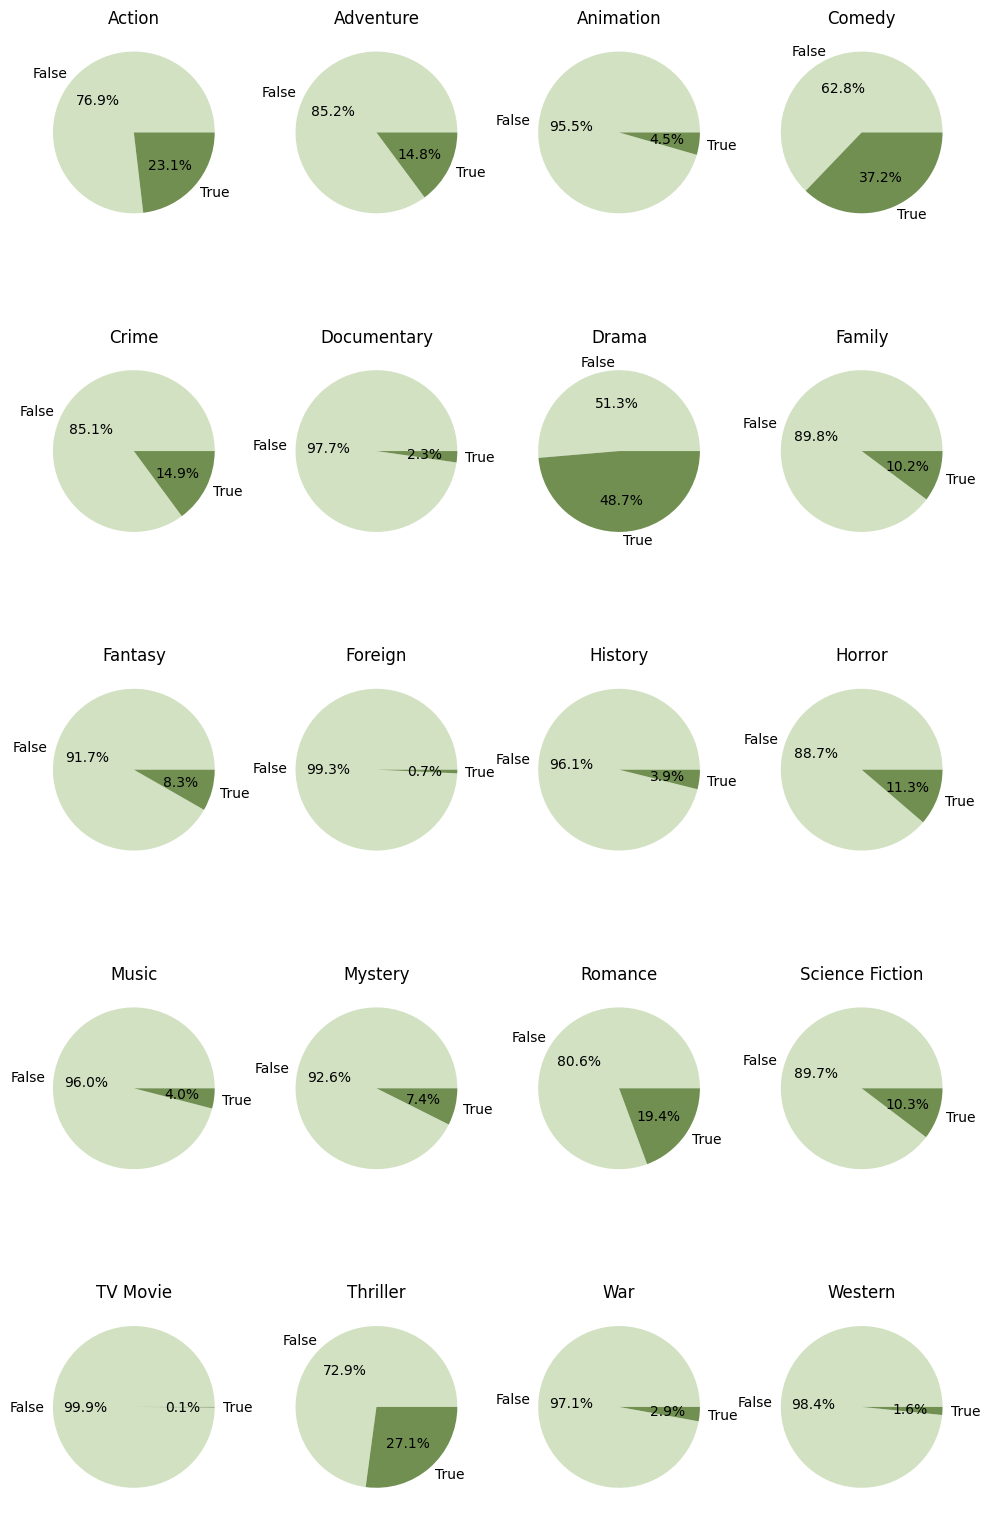

In [5]:
fig, axs = plt.subplots(5, 4, figsize=(12, 20))

for i, col in enumerate(GENRE_COLS):
    ax = axs[i//4, i%4]
    counts = movie_df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=DIS_CMAP(3))
    ax.set_title(col)

#### Status:

status
Released           4513
Rumored               4
Post Production       3
Name: count, dtype: int64


Text(0.5, 1.0, 'Status')

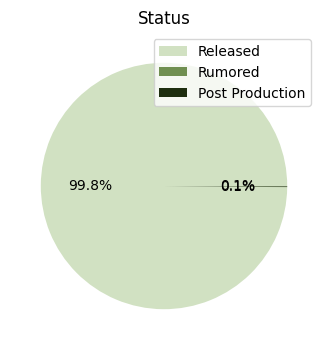

In [6]:
plt.figure(figsize=(4, 4))
counts = movie_df['status'].value_counts()
print(counts)
plt.pie(counts, autopct='%1.1f%%', colors=DIS_CMAP(3))
plt.legend(labels=counts.index, loc='best') 
plt.title('Status')

#### Language:

original_language
en    4231
fr      69
es      32
zh      27
de      27
hi      16
ja      15
it      14
cn      12
ru      11
ko      11
pt       8
da       7
sv       5
nl       4
fa       4
he       3
id       2
ar       2
th       2
ta       2
cs       2
sl       1
xx       1
vi       1
tr       1
te       1
ps       1
ro       1
pl       1
no       1
nb       1
el       1
is       1
hu       1
af       1
Name: count, dtype: int64
0.9360619469026549
36


Text(0.5, 1.0, 'Languages')

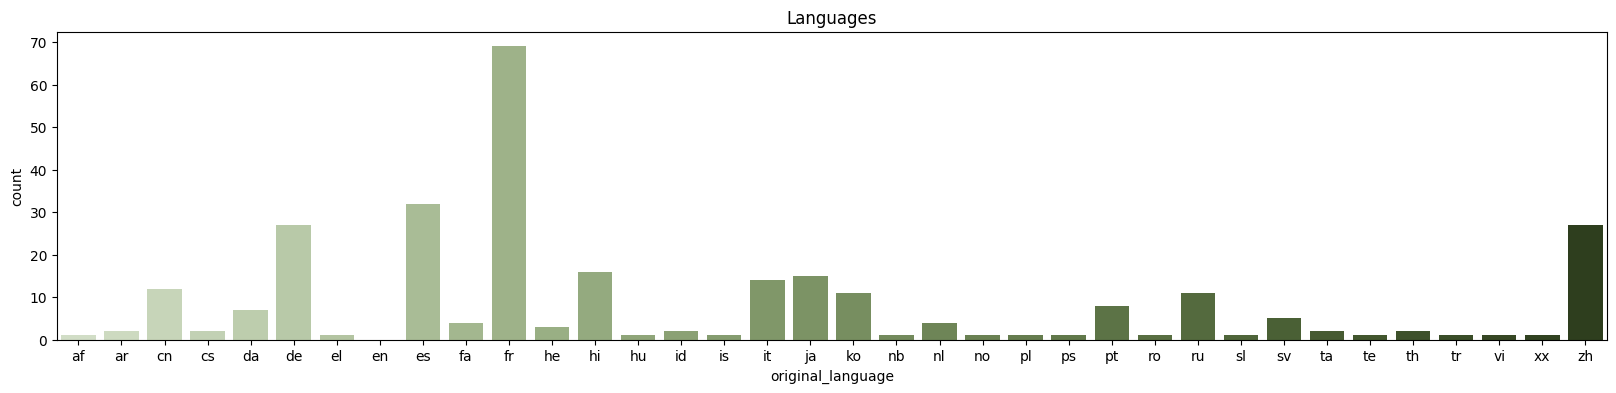

In [7]:
plt.figure(figsize=(20, 4))
lang_dg = movie_df.where(movie_df['original_language'] != 'en').dropna()
counts = movie_df['original_language'].value_counts()

print(counts)
print(counts['en'] / len(movie_df))
print(movie_df['original_language'].nunique())
sns.countplot(data=lang_dg, x='original_language', palette=DIS_CMAP(40))
plt.title('Languages')

#### Numerical Features:

##### **1. Budget:**

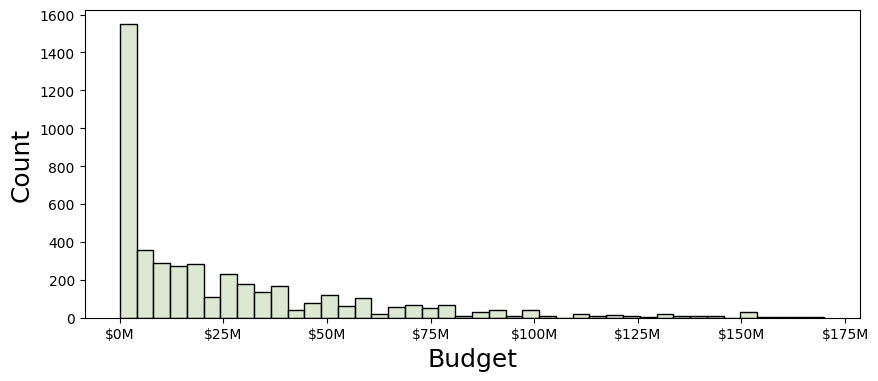

In [8]:
# Plot the histogram
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='budget_millions', color=DIS_CMAP(5)[0])

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Budget", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.show()

##### **2. Popularity:**

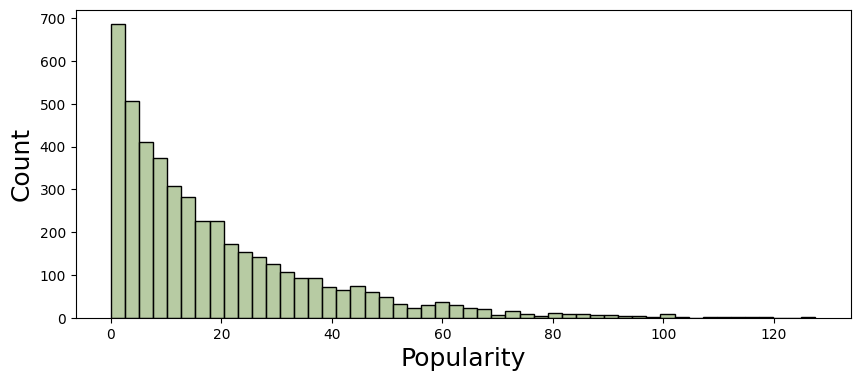

In [9]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='popularity', color=DIS_CMAP(5)[1])

plt.xlabel("Popularity", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.show()

##### **3. Revenue:**

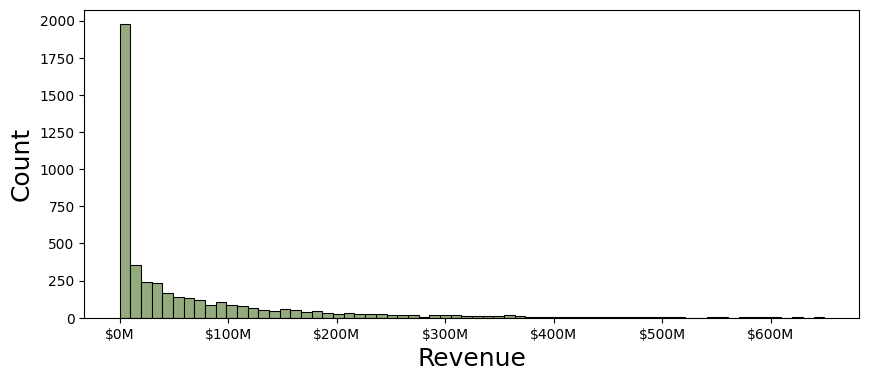

In [10]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='revenue_millions', color=DIS_CMAP(5)[2])

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.xlabel("Revenue", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.show()

##### **4. Runtime:**

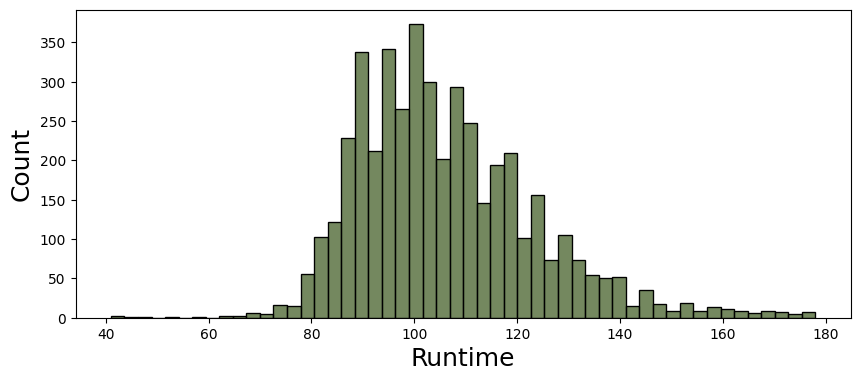

In [11]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='runtime', color=DIS_CMAP(5)[3])

plt.xlabel("Runtime", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.show()

##### **5. Rating:**

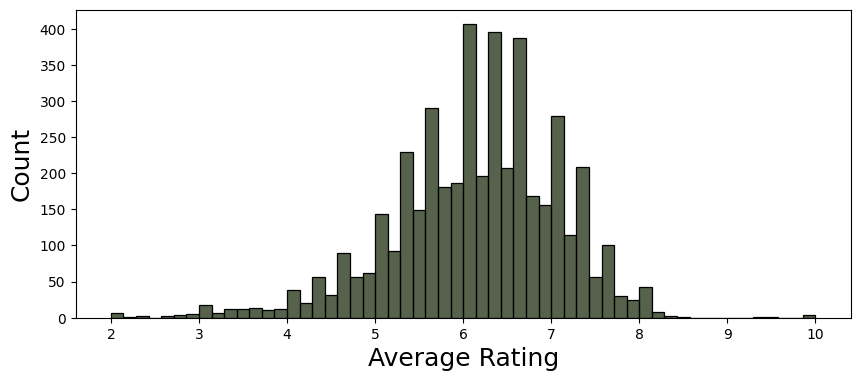

In [12]:
plt.figure(figsize=(10, 4))
sns.histplot(data=movie_df, x='vote_average', color=DIS_CMAP(5)[4])

plt.xlabel("Average Rating", fontsize=18)
plt.ylabel("Count", fontsize=18)

plt.show()

#### Number of Movies in Each Genre:

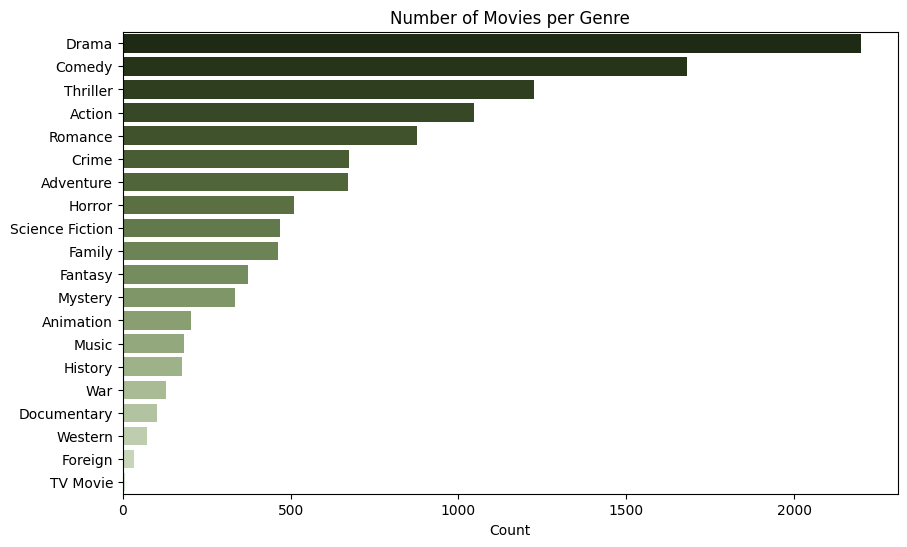

In [13]:
genre_counts = movie_df[GENRE_COLS].sum().reset_index()
genre_counts.columns = ['Genre', 'Count']
genre_counts = genre_counts.sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Genre', data=genre_counts, palette=DIS_CMAP(20, True))
plt.title('Number of Movies per Genre')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

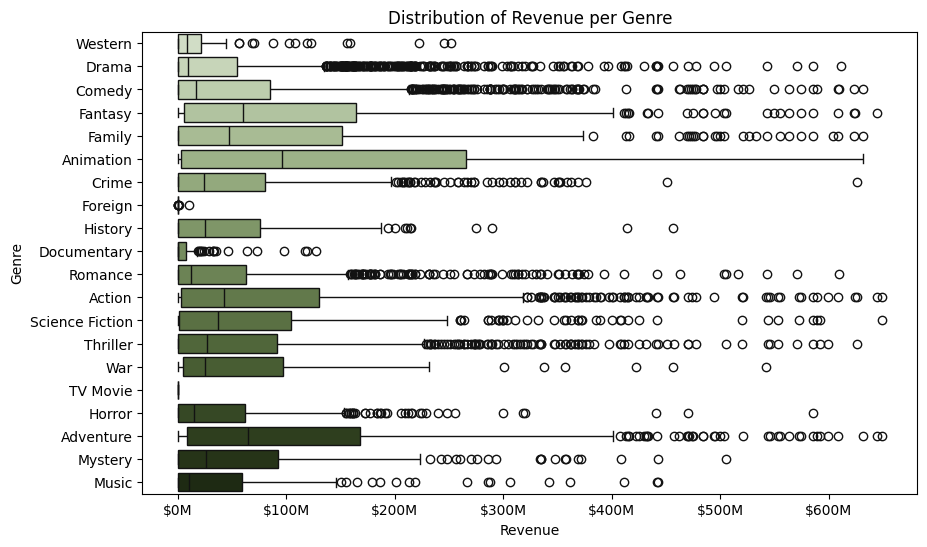

In [14]:
movie_df[GENRE_COLS] = movie_df[GENRE_COLS].fillna(False)
melted_df = movie_df.melt(id_vars='revenue_millions', value_vars=GENRE_COLS, var_name='Genre')
melted_df = melted_df[melted_df['value']].sort_values('revenue_millions')

plt.figure(figsize=(10, 6))
sns.boxplot(x='revenue_millions', y='Genre', data=melted_df, palette=DIS_CMAP(20))
plt.title('Distribution of Revenue per Genre')
plt.xlabel('Revenue')
plt.ylabel('Genre')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

### **Feature Correlations and Importance:**

#### Correlation between genres and revenue:

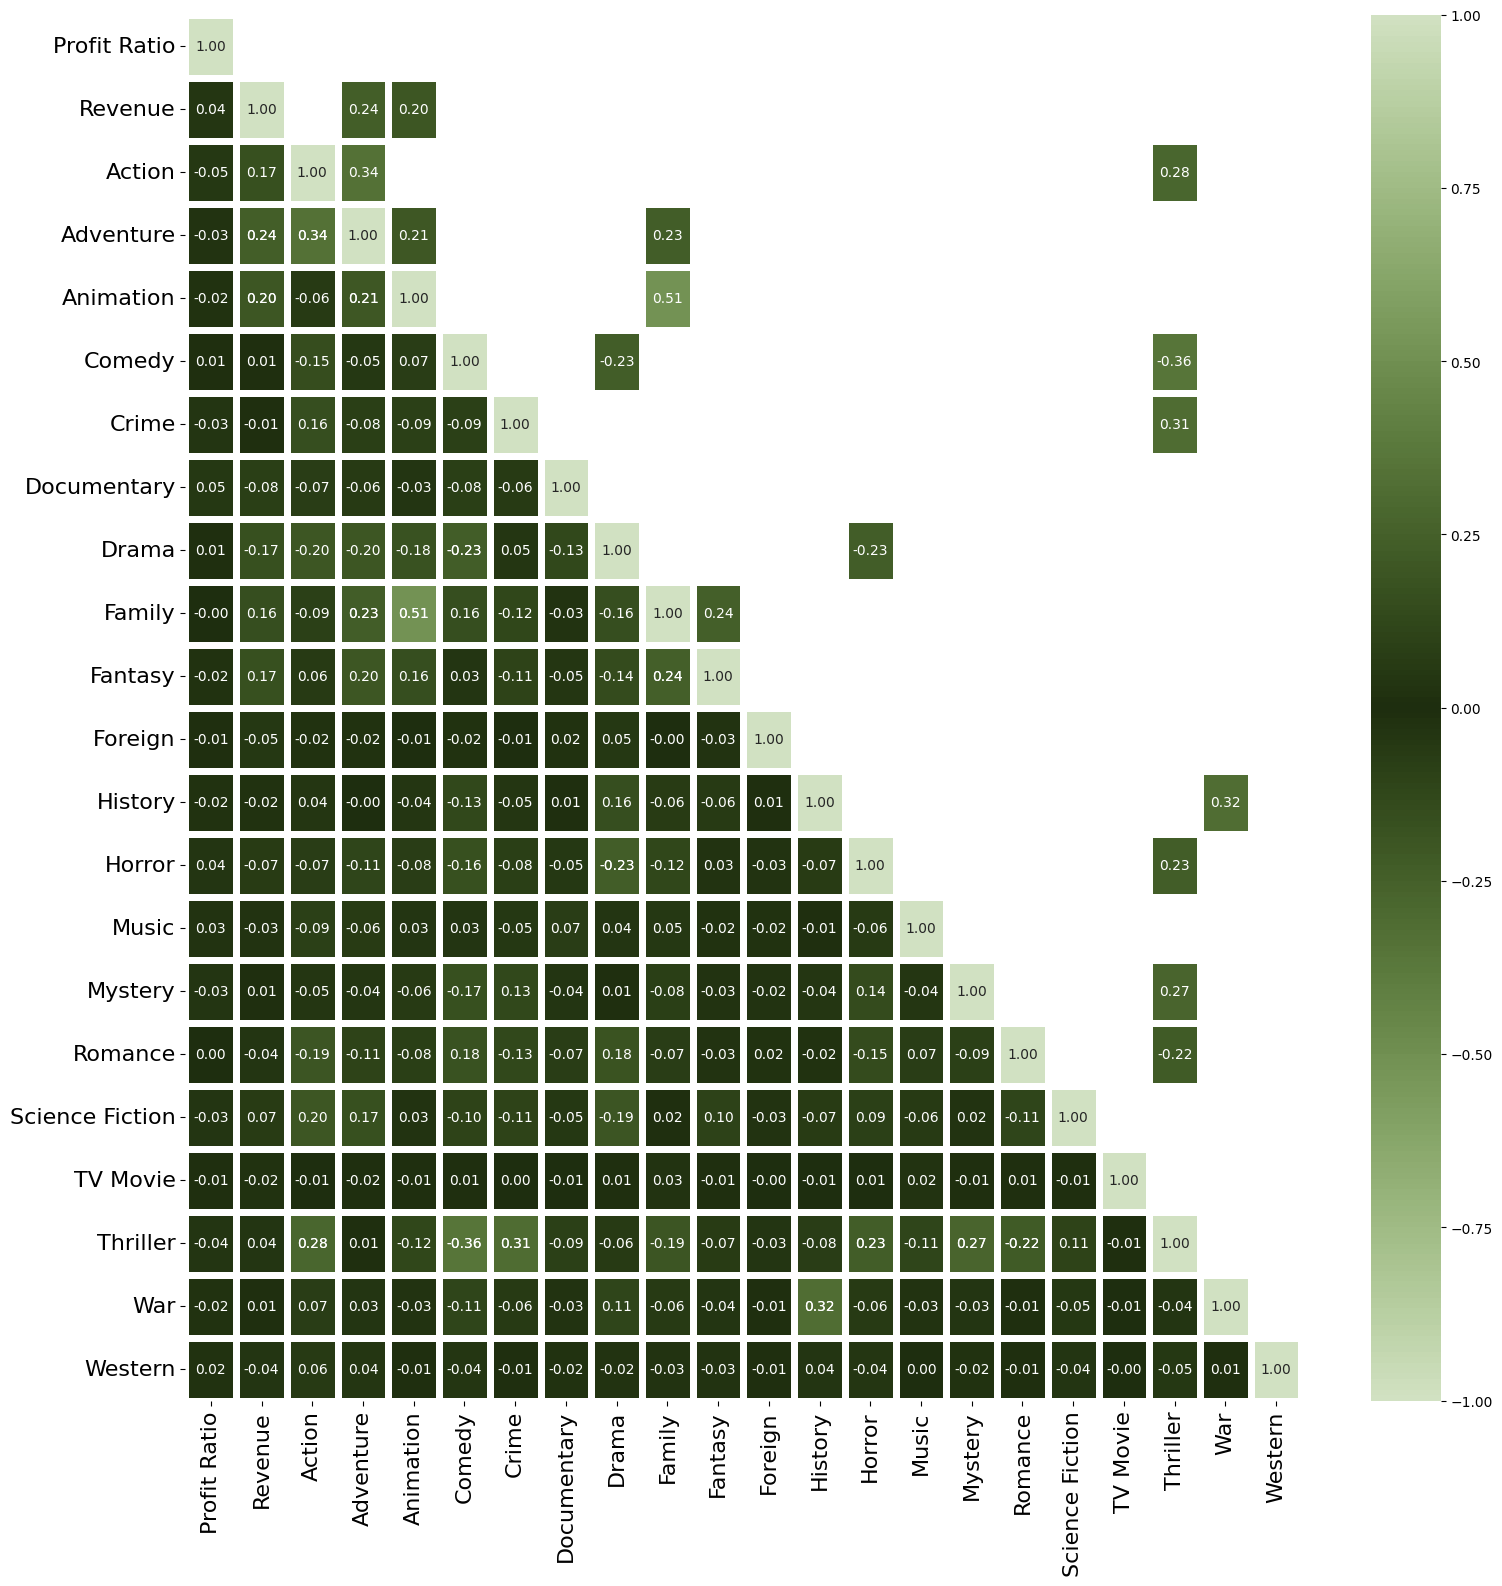

In [15]:
plt.figure(figsize=(18, 18))
genre_rev = ['profit_rate', 'revenue'] + GENRE_COLS
corr_df = movie_df[genre_rev]
corr_df.rename(columns={'profit_rate': 'Profit Ratio',
                        'revenue': 'Revenue',
                        }, inplace=True)

corr = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

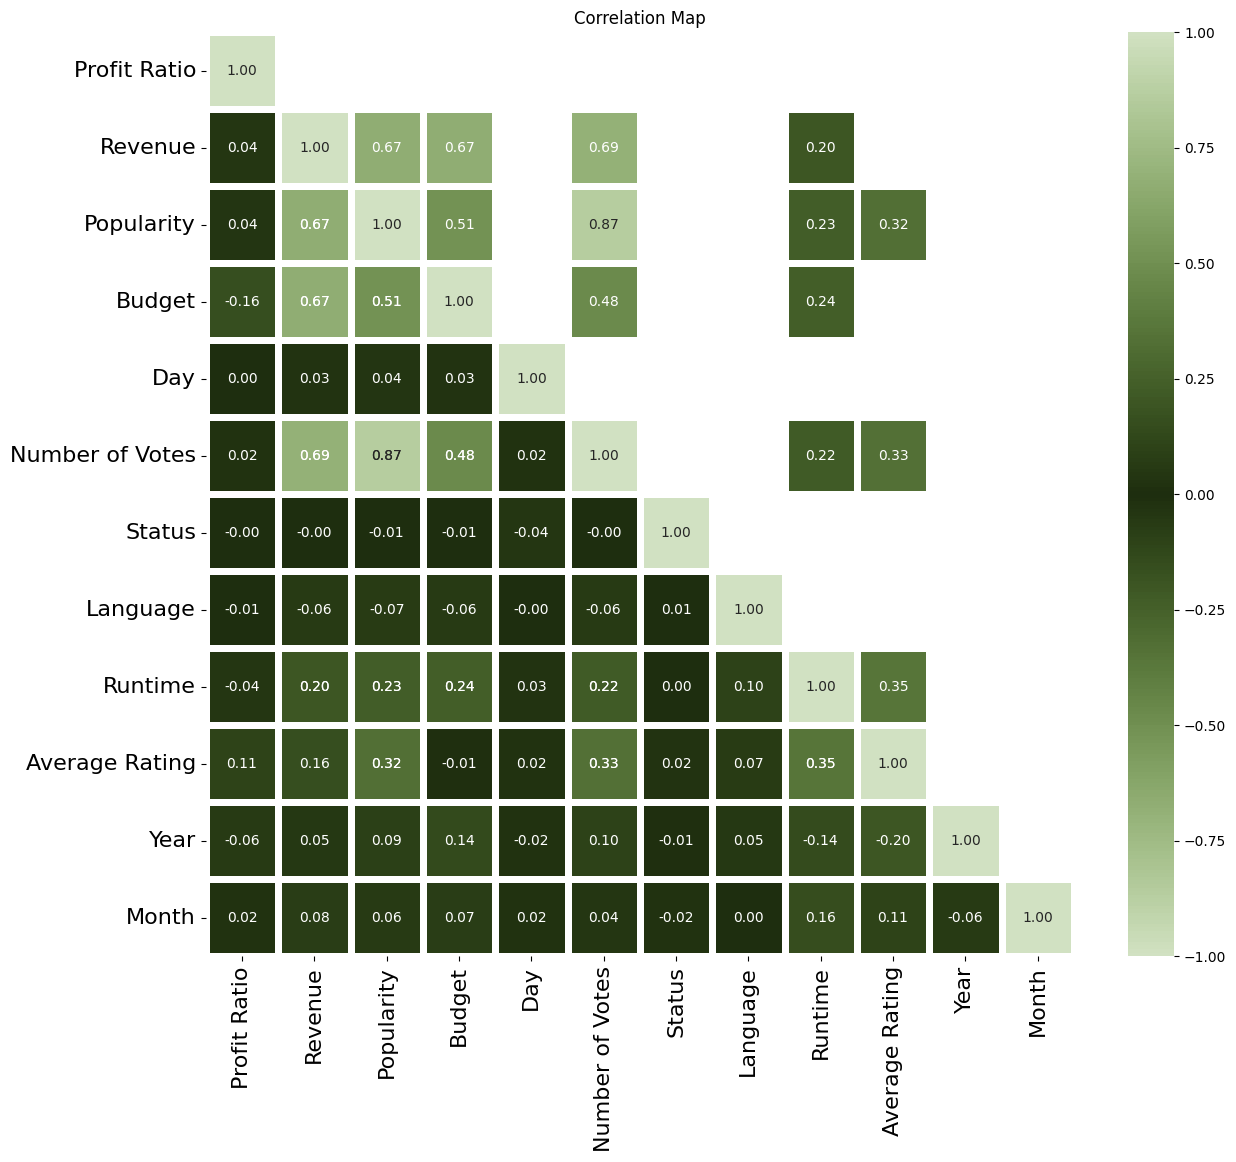

In [16]:
plt.figure(figsize=(14, 12))

genre_rev = ['profit_rate', 'revenue'] + NON_GENRECREW_COLS
corr_df = movie_df[genre_rev]
corr_df.rename(columns={'profit_rate': 'Profit Ratio',
                        'budget': 'Budget',
                        'language_code': 'Language',
                        'runtime': 'Runtime',
                        'vote_average': 'Average Rating',
                        'revenue': 'Revenue',
                        'vote_count': 'Number of Votes',
                        'popularity': 'Popularity',
                        'day': 'Day',
                        'month': 'Month',
                        'year': 'Year',
                        'status_code': 'Status',
                        }, inplace=True)

corr = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)

plt.title('Correlation Map')
plt.show()

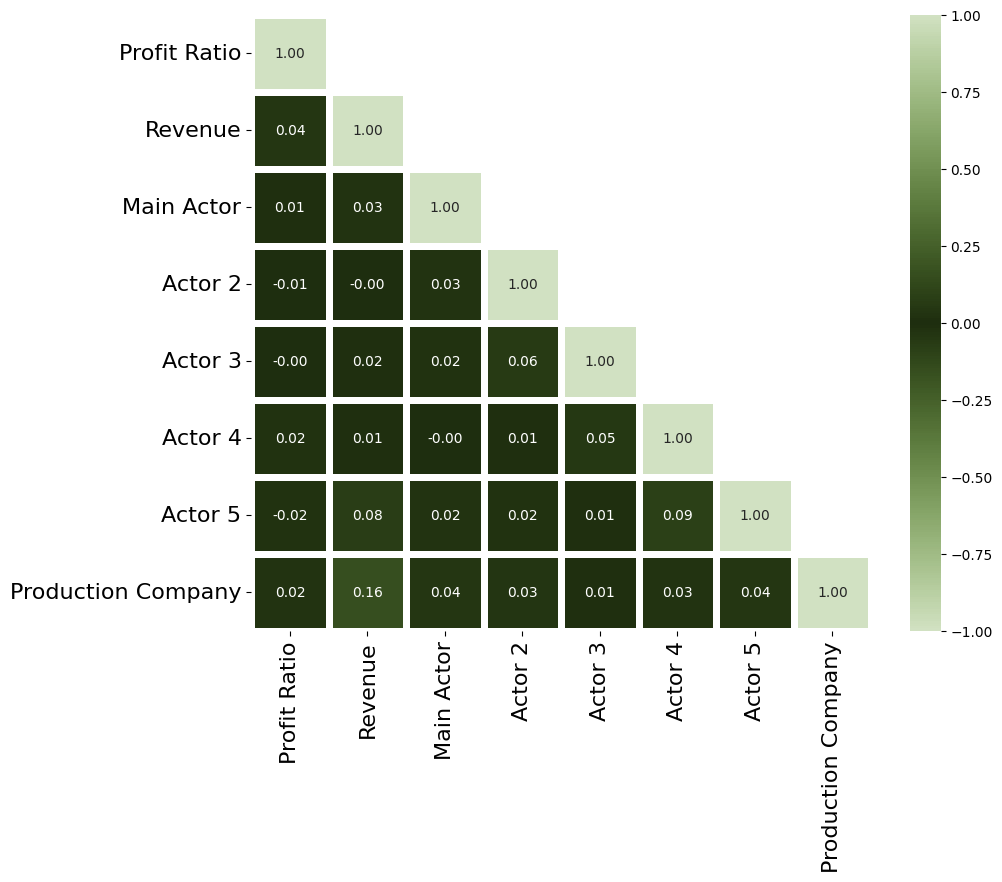

In [17]:
plt.figure(figsize=(10, 8))

crew_rev = ['profit_rate', 'revenue'] + CREW_COLS
corr_df = movie_df[crew_rev]
corr_df.rename(columns={'profit_rate': 'Profit Ratio',
                        'revenue': 'Revenue',
                        'actor_1_code': 'Main Actor',
                        'actor_2_code': 'Actor 2',
                        'actor_3_code': 'Actor 3',
                        'actor_4_code': 'Actor 4',
                        'actor_5_code': 'Actor 5',
                        'production_company_code': 'Production Company',
                        }, inplace=True)

corr = corr_df.corr()
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)

plt.show()

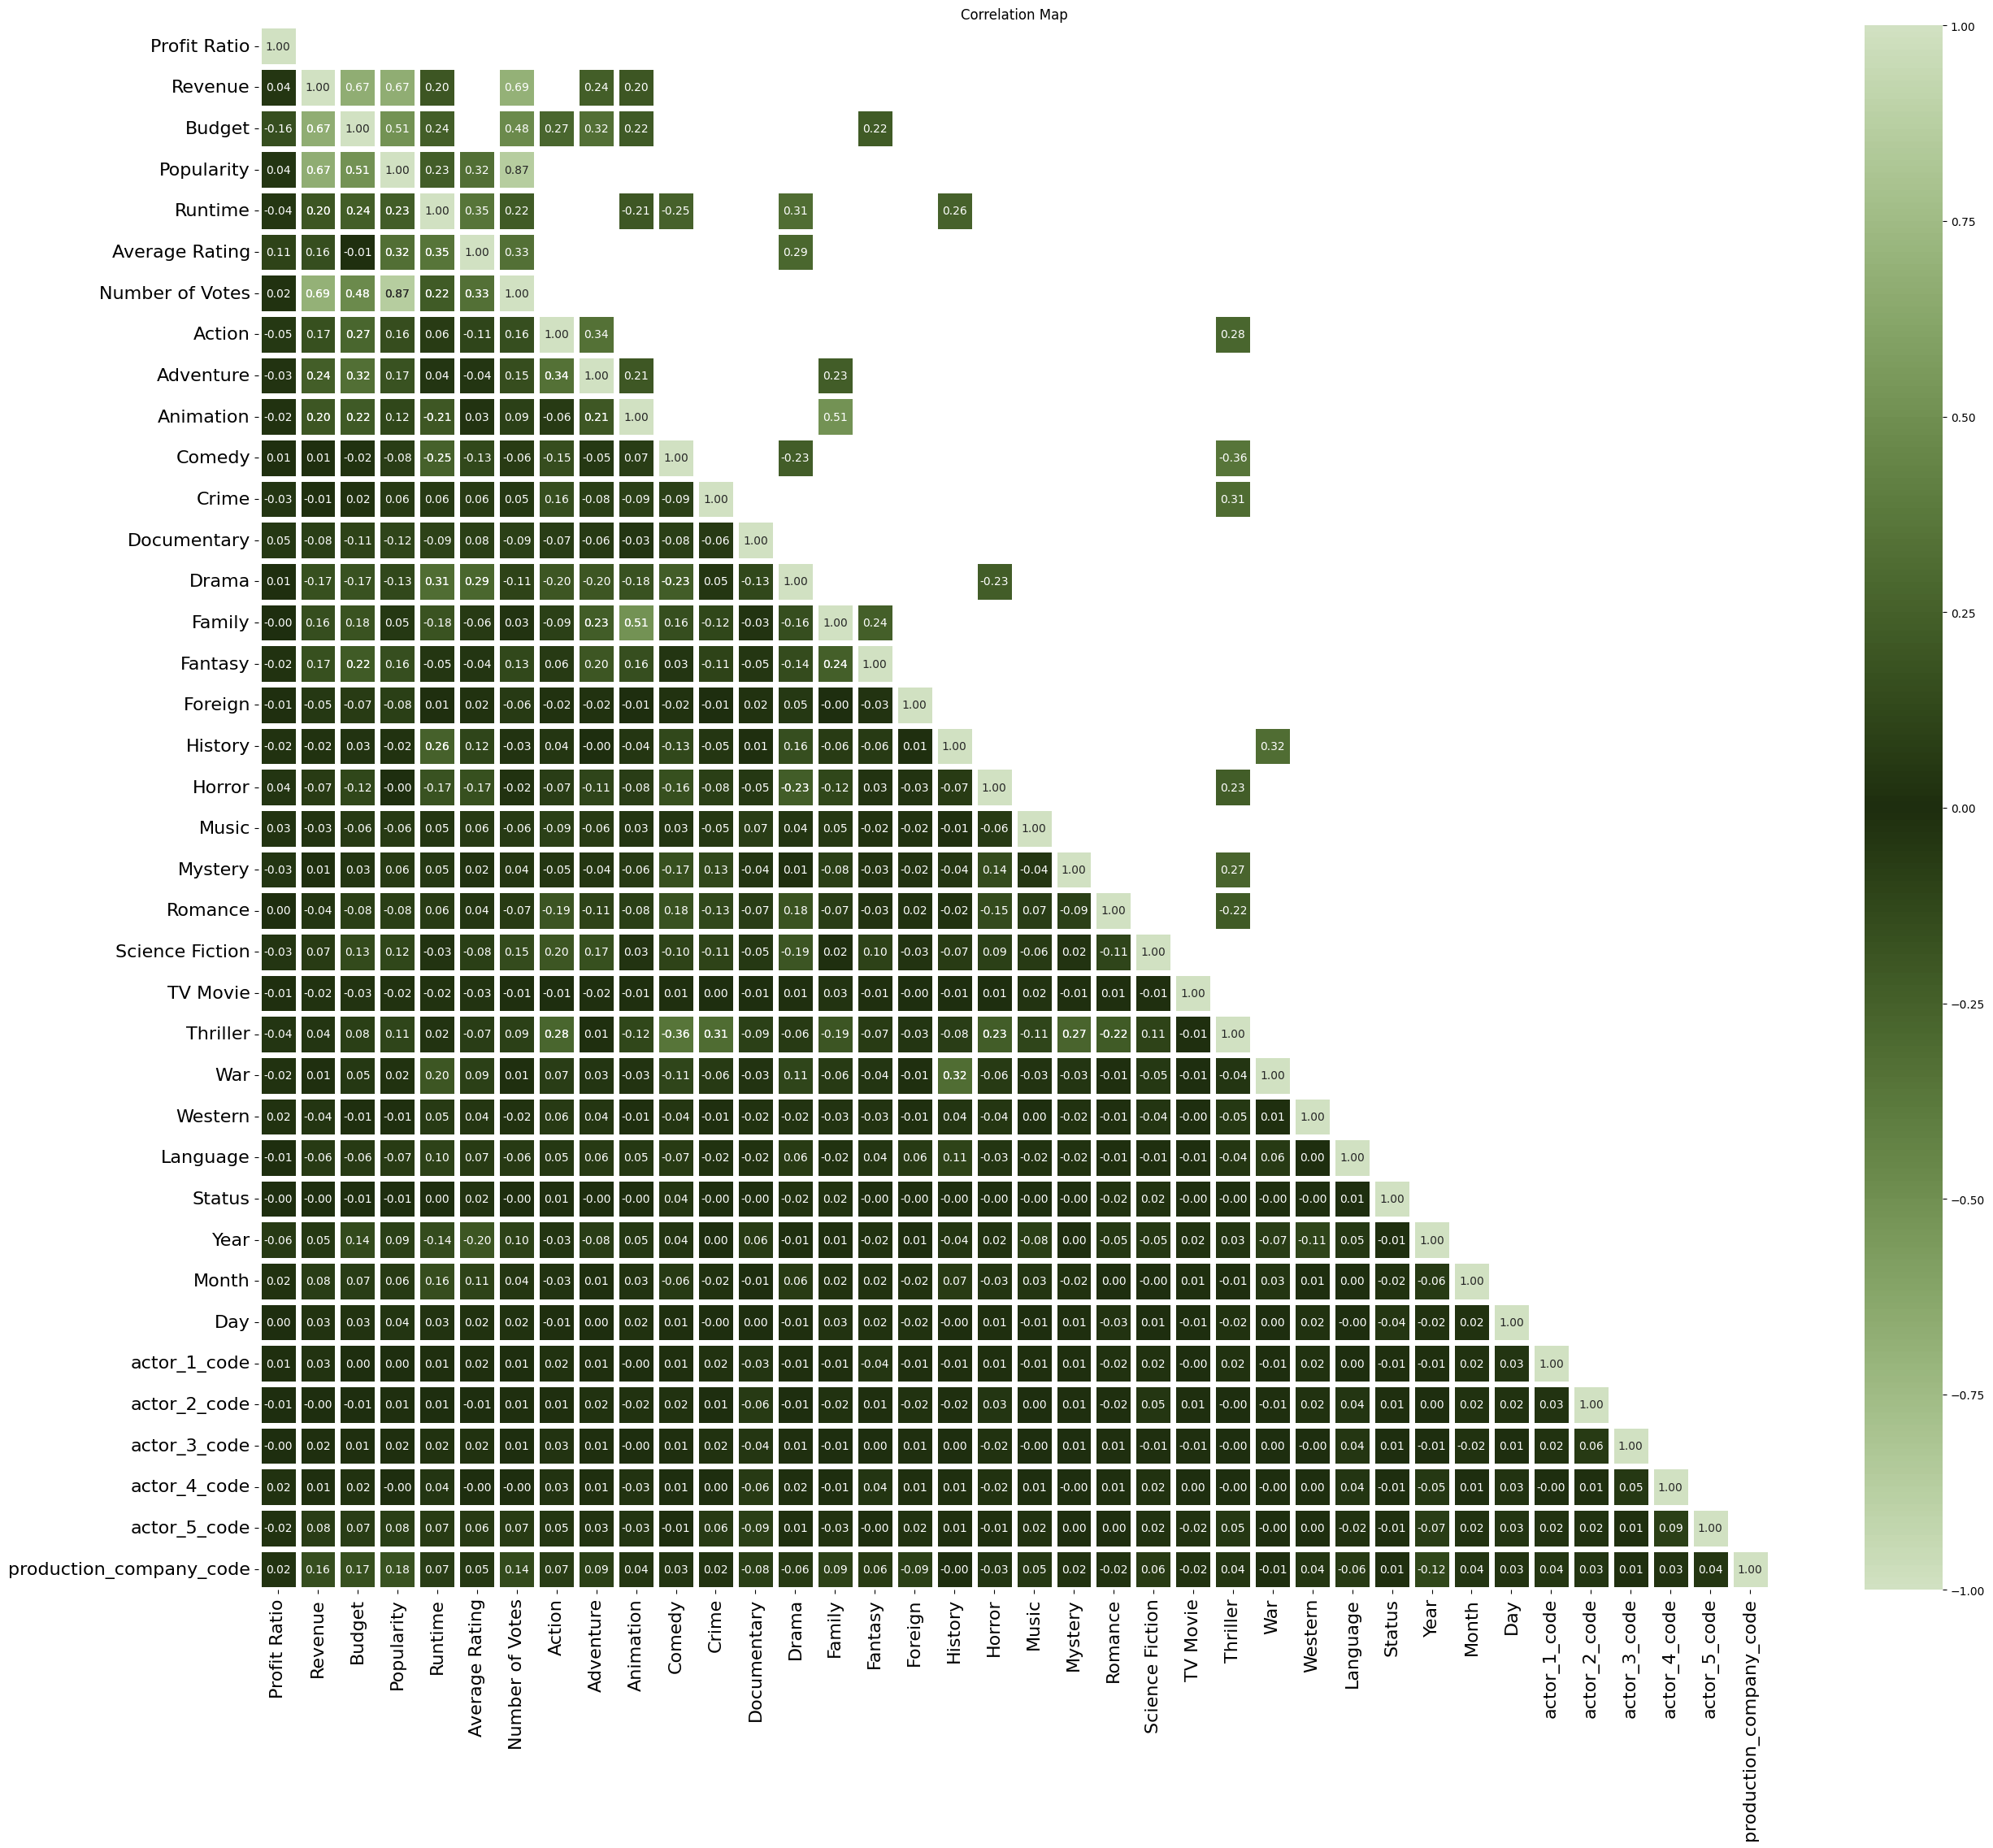

In [18]:
plt.figure(figsize=(30, 25))
nonstr_rev = ['profit_rate', 'revenue'] + NON_STR_COLS

corr_df = movie_df[nonstr_rev]
corr_df.rename(columns={'profit_rate': 'Profit Ratio',
                        'budget': 'Budget',
                        'language_code': 'Language',
                        'runtime': 'Runtime',
                        'vote_average': 'Average Rating',
                        'revenue': 'Revenue',
                        'vote_count': 'Number of Votes',
                        'popularity': 'Popularity',
                        'day': 'Day',
                        'month': 'Month',
                        'year': 'Year',
                        'status_code': 'Status',
                        }, inplace=True)

corr = corr_df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a mask for correlations higher than 0.2
high_corr_mask = np.abs(corr) > 0.2

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=DIV_CMAP, vmax=1, vmin=-1, center=0,
            linewidths=5, annot=True, fmt=".2f")

# Highlight the correlations that are higher than 0.2
sns.heatmap(corr, mask=~high_corr_mask, cmap=DIV_CMAP, cbar=False,
            vmax=1, vmin=-1, center=0, linewidths=5, annot=True, fmt=".2f")

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=16)

plt.title('Correlation Map')
plt.show()

#### Feature Importance:

##### Based On Revenues:

In [19]:
x = movie_df[NON_STR_COLS].astype('category')
x.rename(columns={'profit_rate': 'Profit Ratio',
                  'budget': 'Budget',
                  'language_code': 'Language',
                  'runtime': 'Runtime',
                  'vote_average': 'Average Rating',
                  'revenue': 'Revenue',
                  'vote_count': 'Number of Votes',
                  'popularity': 'Popularity',
                  'day': 'Day',
                  'month': 'Month',
                  'year': 'Year',
                  'status_code': 'Status',
                  'actor_1_code': 'Main Actor',
                  'actor_2_code': 'Actor 2',
                  'actor_3_code': 'Actor 3',
                  'actor_4_code': 'Actor 4',
                  'actor_5_code': 'Actor 5',
                  'production_company_code': 'Production Company',
                    }, inplace=True)
y = movie_df['binned_revenue']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [20]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report_str)

Accuracy: 0.55

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83       466
           1       0.24      0.15      0.19        97
           2       0.15      0.10      0.12        68
           3       0.18      0.10      0.12        52
           4       0.15      0.10      0.12        52
           5       0.12      0.09      0.10        34
           6       0.00      0.00      0.00        14
           7       0.18      0.12      0.15        24
           8       0.20      0.05      0.08        21
           9       0.00      0.00      0.00        11
          10       0.33      0.08      0.13        12
          11       0.40      0.22      0.29         9
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         4
          14       0.25      0.17      0.20         6
          15       0.00      0.00      0.00         5
          16       0.50      0.14      0.2

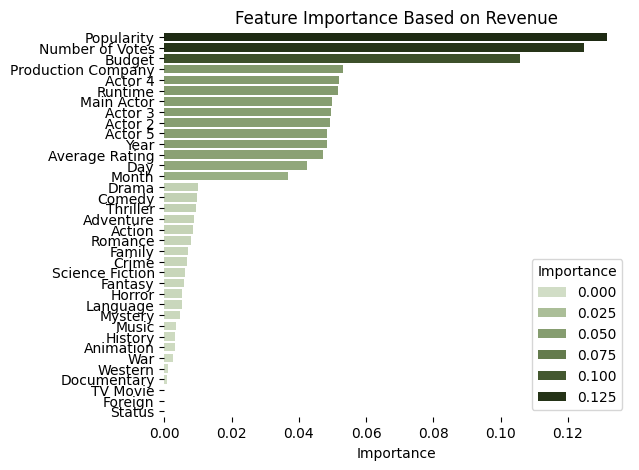

In [21]:
feature_importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=CON_CMAP, hue="Importance")
plt.title('Feature Importance Based on Revenue')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

##### Based On Profits:

In [22]:
x = movie_df[NON_STR_COLS].astype('category')
x.rename(columns={'profit_rate': 'Profit Ratio',
                  'budget': 'Budget',
                  'language_code': 'Language',
                  'runtime': 'Runtime',
                  'vote_average': 'Average Rating',
                  'revenue': 'Revenue',
                  'vote_count': 'Number of Votes',
                  'popularity': 'Popularity',
                  'day': 'Day',
                  'month': 'Month',
                  'year': 'Year',
                  'status_code': 'Status',
                  'actor_1_code': 'Main Actor',
                  'actor_2_code': 'Actor 2',
                  'actor_3_code': 'Actor 3',
                  'actor_4_code': 'Actor 4',
                  'actor_5_code': 'Actor 5',
                  'production_company_code': 'Production Company',
                  }, inplace=True)
y = movie_df['binned_profit']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('\nClassification Report:')
print(classification_report_str)

Accuracy: 0.75

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.87       674
           1       0.34      0.18      0.23       119
           2       0.00      0.00      0.00        36
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         2
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          17       0.00      0.00      0.00         1
          25       0.00      0.00      0.00         2
          29       0.50      0.06      0.10        36

    accuracy                           0.75       904
   macro avg       0.11      0.08      0.

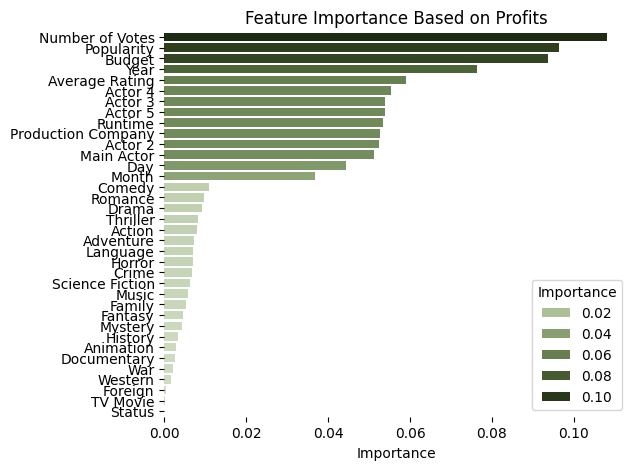

In [24]:
feature_importance = clf.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(6, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette=CON_CMAP, hue="Importance")
plt.title('Feature Importance Based on Profits')
plt.xlabel('Importance')
plt.ylabel('')
sns.despine(left=True, bottom=True)
plt.show()

### **Exploratory Data Analysis:**

#### Popularity:

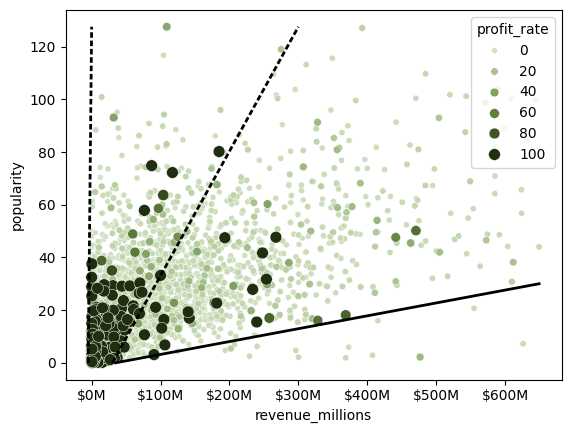

In [55]:
temp_df = movie_df.sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='revenue_millions', y='popularity',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

ax.plot([temp_df['revenue_millions'].min()+30, 300], [0, temp_df['popularity'].max()], color='black', linewidth=2, linestyle=(0, (2, 1)))
ax.plot([-5, 0], [0, temp_df['popularity'].max()], color='black', linewidth=2, linestyle=(0, (2, 1)))
ax.plot([temp_df['revenue_millions'].min()+35, temp_df['revenue_millions'].max()], [0, 30], color='black', linewidth=2)

plt.show()

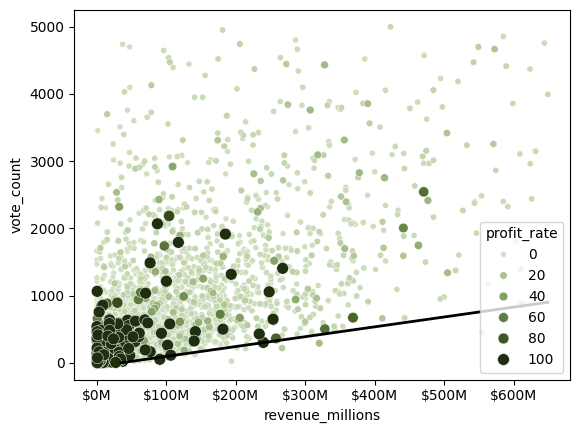

In [53]:
temp_df = movie_df.sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='revenue_millions', y='vote_count',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

ax.plot([temp_df['revenue_millions'].min()+35, temp_df['revenue_millions'].max()], [0, 900], color='black', linewidth=2)

plt.show()

In [66]:
movie_df.where(movie_df['revenue_millions'] > 300).where(movie_df['profit_rate'] > 50).dropna()

,ID,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,...,production_company_code,year,month,day,binned_revenue,profit_rate,revenue_millions,budget_millions,binned_profit,decade
209,209.0,Jaws,7000000.0,"[{'id': 1495, 'name': 'fishing'}, {'id': 1913,...",en,50.152327,1975-06-18,470654000.0,124.0,Released,...,1188.0,1975.0,6.0,18.0,21.0,67.236286,470.654000,7.0,20.0,1970.0
1011,1011.0,My Big Fat Greek Wedding,5000000.0,"[{'id': 279, 'name': 'usa'}, {'id': 970, 'name...",en,18.115566,2002-02-22,368744044.0,95.0,Released,...,555.0,2002.0,2.0,22.0,17.0,73.748809,368.744044,5.0,22.0,2000.0
1274,1274.0,The Exorcist,8000000.0,"[{'id': 2626, 'name': 'exorcism'}, {'id': 3649...",en,47.584643,1973-12-26,441306145.0,122.0,Released,...,1224.0,1973.0,12.0,26.0,20.0,55.163268,441.306145,8.0,16.0,1970.0
1324,1324.0,Crocodile Dundee,5000000.0,"[{'id': 242, 'name': 'new york'}, {'id': 549, ...",en,16.072466,1986-09-26,328203506.0,97.0,Released,...,868.0,1986.0,9.0,26.0,15.0,65.640701,328.203506,5.0,19.0,1980.0


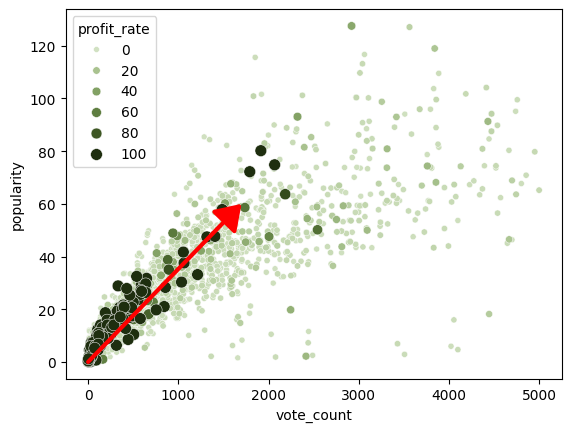

In [26]:
temp_df = movie_df.sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='vote_count', y='popularity',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

prop = dict(arrowstyle="-|>,head_width=1,head_length=1.5",
            shrinkA=0, shrinkB=0, linewidth=3, facecolor='red', edgecolor='red')
plt.annotate("", xy=(1700,60), xytext=(0,0), arrowprops=prop)
ax = plt.gca()

plt.show()


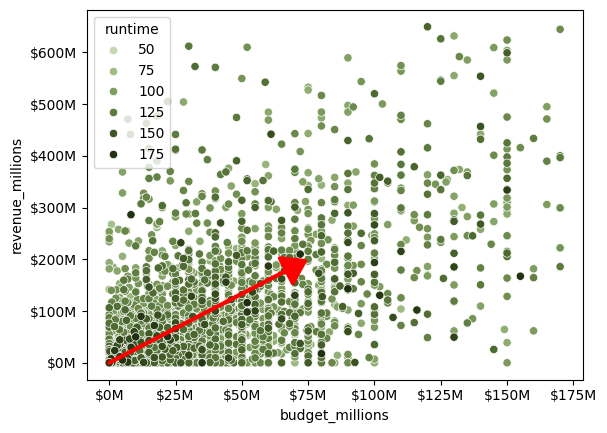

In [74]:
temp_df = movie_df.sort_values('runtime', ascending=True)

sns.scatterplot(data=temp_df, y='revenue_millions', x='budget_millions',
                palette=CON_CMAP, hue='runtime')

ax = plt.gca()

prop = dict(arrowstyle="-|>,head_width=1,head_length=1.5",
            shrinkA=0, shrinkB=0, linewidth=3, facecolor='red', edgecolor='red')
plt.annotate("", xy=(75,200), xytext=(0,0), arrowprops=prop)

formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

plt.show()

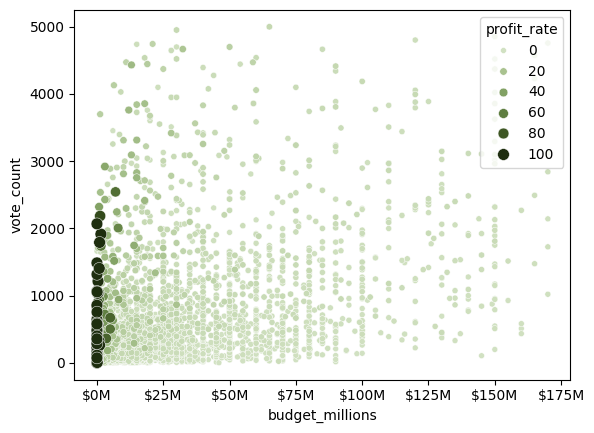

In [ ]:
temp_df = movie_df.sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='budget_millions', y='vote_count',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

In [79]:
movie_df.where(movie_df['profit_rate'] > 20).dropna().sort_values('budget_millions')

,ID,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,...,production_company_code,year,month,day,binned_revenue,profit_rate,revenue_millions,budget_millions,binned_profit,decade
2120,2120.0,Semi-Pro,0.0,"[{'id': 6075, 'name': 'sport'}, {'id': 6496, '...",en,10.449975,2008-02-28,33472850.0,91.0,Released,...,798.0,2008.0,2.0,28.0,1.0,100.000000,33.472850,0.0,29.0,2000.0
1484,1484.0,Hot Rod,0.0,"[{'id': 5956, 'name': 'stuntman'}, {'id': 6669...",en,6.309587,2007-08-03,14334401.0,88.0,Released,...,868.0,2007.0,8.0,3.0,0.0,100.000000,14.334401,0.0,29.0,2000.0
3528,3528.0,Mooz-lum,0.0,"[{'id': 10183, 'name': 'independent film'}]",en,0.414754,2011-02-11,330048.0,95.0,Released,...,0.0,2011.0,2.0,11.0,0.0,100.000000,0.330048,0.0,29.0,2010.0
1599,1599.0,The Muppet Christmas Carol,0.0,"[{'id': 65, 'name': 'holiday'}, {'id': 2964, '...",en,15.085981,1992-12-10,27281507.0,85.0,Released,...,1219.0,1992.0,12.0,10.0,1.0,100.000000,27.281507,0.0,29.0,1990.0
1615,1615.0,Bats,0.0,"[{'id': 2766, 'name': 'mutation'}, {'id': 5155...",en,1.537859,1999-10-22,10.0,91.0,Released,...,319.0,1999.0,10.0,22.0,0.0,100.000000,0.000010,0.0,29.0,1990.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,1.0,American Beauty,15000000.0,"[{'id': 255, 'name': 'male nudity'}, {'id': 29...",en,80.878605,1999-09-15,356296601.0,122.0,Released,...,341.0,1999.0,9.0,15.0,16.0,23.753107,356.296601,15.0,7.0,1990.0
295,295.0,Home Alone,18000000.0,"[{'id': 65, 'name': 'holiday'}, {'id': 1437, '...",en,2.186927,1990-11-09,476684675.0,103.0,Released,...,1173.0,1990.0,11.0,9.0,22.0,26.482482,476.684675,18.0,7.0,1990.0
30,30.0,Raiders of the Lost Ark,18000000.0,"[{'id': 83, 'name': 'saving the world'}, {'id'...",en,68.159596,1981-06-12,389925971.0,115.0,Released,...,702.0,1981.0,6.0,12.0,18.0,21.662554,389.925971,18.0,6.0,1980.0
103,103.0,Ghost,22000000.0,"[{'id': 417, 'name': 'corruption'}, {'id': 663...",en,41.967005,1990-07-12,505000000.0,127.0,Released,...,868.0,1990.0,7.0,12.0,23.0,22.954545,505.000000,22.0,6.0,1990.0


In [87]:
losing_df = movie_df.where(movie_df['profit_rate'] < 1).dropna().sort_values('budget_millions')
losing_df.head()

,ID,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,...,production_company_code,year,month,day,binned_revenue,profit_rate,revenue_millions,budget_millions,binned_profit,decade
4519,4519.0,Growing Up Smith,0.0,[],en,0.710870,2017-02-03,0.0,102.0,Released,...,0.0,2017.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,2010.0
2504,2504.0,Lesbian Vampire Killers,0.0,"[{'id': 293, 'name': 'female nudity'}, {'id': ...",en,6.632891,2009-03-16,0.0,86.0,Released,...,27.0,2009.0,3.0,16.0,0.0,0.0,0.0,0.0,0.0,2000.0
4023,4023.0,They Came Together,0.0,[],en,12.036888,2014-06-27,0.0,84.0,Released,...,693.0,2014.0,6.0,27.0,0.0,0.0,0.0,0.0,0.0,2010.0
2497,2497.0,Duets,0.0,"[{'id': 4344, 'name': 'musical'}]",en,2.254530,2000-09-09,0.0,112.0,Released,...,554.0,2000.0,9.0,9.0,0.0,0.0,0.0,0.0,0.0,2000.0
2496,2496.0,Next Day Air,0.0,"[{'id': 179431, 'name': 'duringcreditsstinger'}]",en,2.747402,2009-02-06,0.0,84.0,Released,...,742.0,2009.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,2000.0


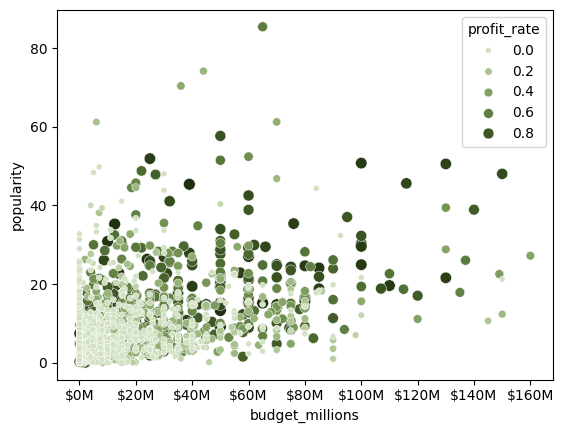

In [92]:
losing_df.sort_values('profit_rate', ascending=False, inplace=True)
sns.scatterplot(data=losing_df, x='budget_millions', y='popularity',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

In [94]:
losing_df.where(losing_df['popularity'] > 60).dropna()

,ID,title,budget,keywords,original_language,popularity,release_date,revenue,runtime,status,...,production_company_code,year,month,day,binned_revenue,profit_rate,revenue_millions,budget_millions,binned_profit,decade
78,78.0,Sin City: A Dame to Kill For,65000000.0,"[{'id': 703, 'name': 'detective'}, {'id': 4565...",en,85.428395,2014-08-20,39407616.0,102.0,Released,...,765.0,2014.0,8.0,20.0,1.0,0.606271,39.407616,65.0,0.0,2010.0
298,298.0,Gattaca,36000000.0,"[{'id': 856, 'name': 'paraplegic'}, {'id': 125...",en,70.398356,1997-09-07,12532777.0,106.0,Released,...,254.0,1997.0,9.0,7.0,0.0,0.348133,12.532777,36.0,0.0,1990.0
1580,1580.0,The Iron Giant,70000000.0,"[{'id': 2106, 'name': 'cold war'}, {'id': 6054...",en,61.245957,1999-08-06,23159305.0,86.0,Released,...,1225.0,1999.0,8.0,6.0,1.0,0.330847,23.159305,70.0,0.0,1990.0
4152,4152.0,The Interview,44000000.0,"[{'id': 591, 'name': 'cia'}, {'id': 6285, 'nam...",en,74.168016,2014-12-25,12342632.0,112.0,Released,...,254.0,2014.0,12.0,25.0,0.0,0.280514,12.342632,44.0,0.0,2010.0
51,51.0,Donnie Darko,6000000.0,"[{'id': 970, 'name': 'parents kids relationshi...",en,61.210016,2001-01-18,1270522.0,113.0,Released,...,858.0,2001.0,1.0,18.0,0.0,0.211754,1.270522,6.0,0.0,2000.0


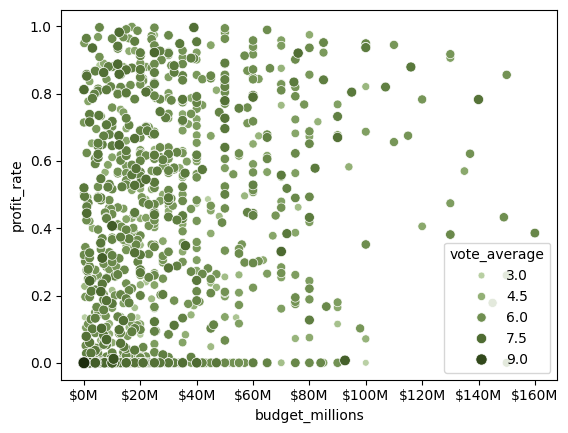

In [101]:
losing_df.sort_values('vote_average', ascending=True, inplace=True)
sns.scatterplot(data=losing_df, x='budget_millions', y='profit_rate',
                palette=CON_CMAP, hue='vote_average', size='vote_average')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

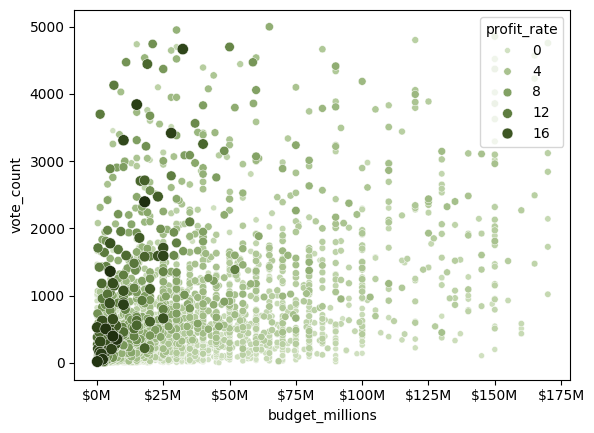

In [78]:
temp_df = movie_df.where(movie_df['profit_rate'] < 20).dropna().sort_values('profit_rate', ascending=True)

sns.scatterplot(data=temp_df, x='budget_millions', y='vote_count',
                palette=CON_CMAP, hue='profit_rate', size='profit_rate')

ax = plt.gca()
formatter = ticker.FormatStrFormatter('$%1.0fM')
ax.xaxis.set_major_formatter(formatter)

plt.show()

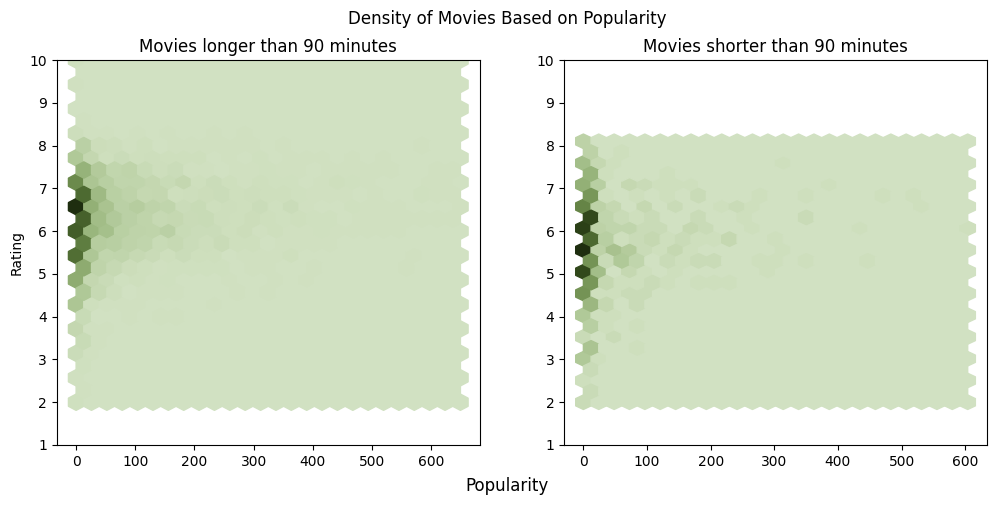

In [40]:
fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("Density of Movies Based on Popularity")
fig.supxlabel("Popularity")

axs[0].set_ylabel("Rating")
axs[0].set_title('Movies longer than 90 minutes')
axs[1].set_title('Movies shorter than 90 minutes')

temp1_df = movie_df[movie_df['runtime'] > 90]
temp2_df = movie_df[movie_df['runtime'] < 90]

hb = axs[0].hexbin(temp1_df['revenue_millions'], temp1_df['vote_average'], gridsize=25, cmap=CON_CMAP)
hb = axs[1].hexbin(temp2_df['revenue_millions'], temp2_df['vote_average'], gridsize=(25, 12), cmap=CON_CMAP)

axs[0].set_ylim([1, 10])
axs[1].set_ylim([1, 10])

plt.show()

   decade  budget_millions
0    1920        23.311000
1    1930         1.152369
2    1940         1.837280
3    1950         2.690132
4    1960         3.987904
5    1970         6.845997
6    1980        12.706819
7    1990        27.961516
8    2000        27.277173
9    2010        25.999956


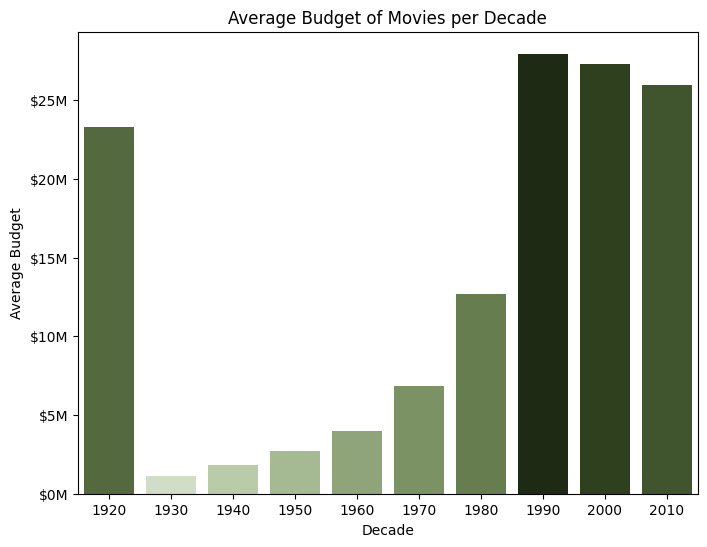

In [147]:
plt.figure(figsize=(8, 6))

temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_budget_millions_per_decade = temp_df.groupby('decade')['budget_millions'].mean().reset_index()
print(average_budget_millions_per_decade)

sns.barplot(x='decade', y='budget_millions', data=average_budget_millions_per_decade, palette=DIS_CMAP(10), hue='budget_millions')

plt.title('Average Budget of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Budget')
plt.legend().remove()

ax = plt.gca()
yformatter = ticker.FormatStrFormatter('$%1.0fM')
ax.yaxis.set_major_formatter(yformatter)

plt.show()

   decade  revenue_millions
0    1920          6.752105
1    1930         19.366613
2    1940         23.710031
3    1950         14.756551
4    1960         30.399248
5    1970         51.841583
6    1980         56.372550
7    1990         68.281529
8    2000         59.554230
9    2010         65.718109


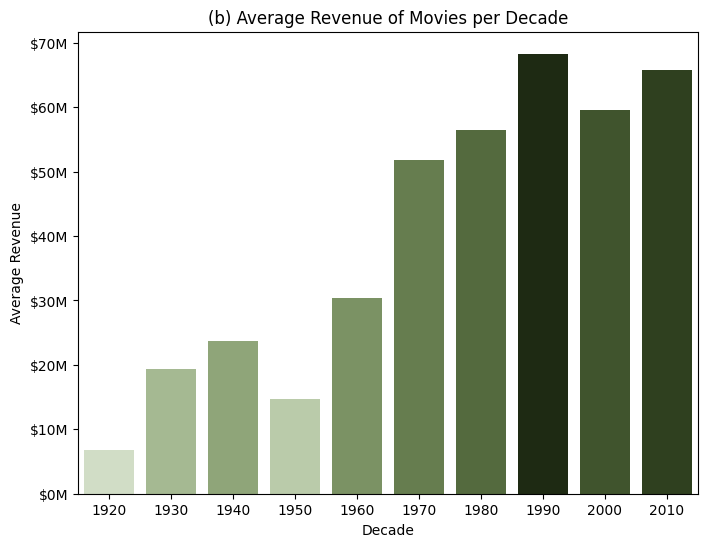

In [148]:
plt.figure(figsize=(8, 6))
temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_revenue_millions_per_decade = temp_df.groupby('decade')['revenue_millions'].mean().reset_index()
print(average_revenue_millions_per_decade)
sns.barplot(x='decade', y='revenue_millions', data=average_revenue_millions_per_decade, palette=DIS_CMAP(10), hue='revenue_millions')

plt.title('(b) Average Revenue of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Revenue')
plt.legend().remove()

ax = plt.gca()
yformatter = ticker.FormatStrFormatter('$%1.0fM')
ax.yaxis.set_major_formatter(yformatter)

plt.show()

In [107]:
65.718109 / 19.366613

3.3933713138172377

   decade  budget_millions
0    1920        23.311000
1    1930         1.152369
2    1940         1.837280
3    1950         2.690132
4    1960         3.987904
5    1970         6.845997
6    1980        12.706819
7    1990        27.961516
8    2000        27.277173
9    2010        25.999956


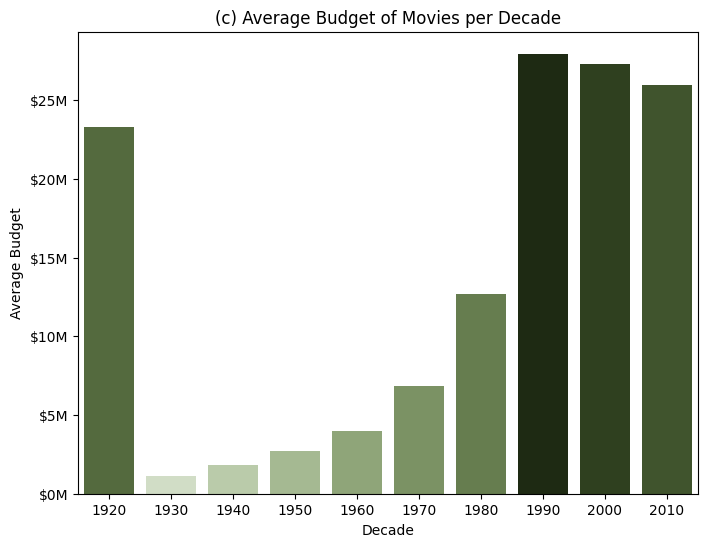

In [149]:
plt.figure(figsize=(8, 6))
temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_budget_millions_per_decade = temp_df.groupby('decade')['budget_millions'].mean().reset_index()
print(average_budget_millions_per_decade)
sns.barplot(x='decade', y='budget_millions', data=average_budget_millions_per_decade, palette=DIS_CMAP(10), hue='budget_millions')

plt.title('(c) Average Budget of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Budget')
plt.legend().remove()

ax = plt.gca()
yformatter = ticker.FormatStrFormatter('$%1.0fM')
ax.yaxis.set_major_formatter(yformatter)

plt.show()

In [106]:
25.999956 / 1.152369

22.562179301942347

0     0.289653
1    16.805915
2    12.904963
3     5.485437
4     7.622864
5     7.572539
6     4.436401
7     2.441982
8     2.183299
9     2.527624
Name: revenue_budget_ratio, dtype: float64


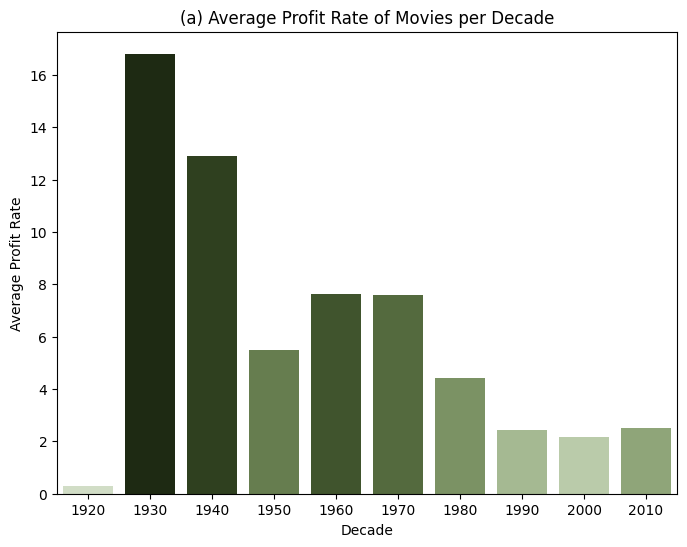

In [150]:
plt.figure(figsize=(8, 6))
temp_df = movie_df
temp_df['decade'] = (temp_df['year'] // 10) * 10

average_ratio_per_decade = average_revenue_millions_per_decade.copy()
average_ratio_per_decade['revenue_budget_ratio'] = average_revenue_millions_per_decade['revenue_millions'] \
    / average_budget_millions_per_decade['budget_millions']
print(average_ratio_per_decade['revenue_budget_ratio'])
sns.barplot(x='decade', y='revenue_budget_ratio', data=average_ratio_per_decade, palette=DIS_CMAP(10), hue='revenue_budget_ratio')

plt.title('(a) Average Profit Rate of Movies per Decade')
plt.xlabel('Decade')
plt.ylabel('Average Profit Rate')
plt.legend().remove()

plt.show()

#### US Inflation by decade:

In [132]:
data = [
    ['1929', '0.60%'], ['1930', '-6.40%'],
    ['1931', '-9.30%'], ['1932', '-10.30%'],
    ['1933', '0.80%'], ['1934', '1.50%'],
    ['1935', '3.00%'], ['1936', '1.40%'],
    ['1937', '2.90%'], ['1938', '-2.80%'],
    ['1939', '0.00%'], ['1940', '0.70%'],
    ['1941', '9.90%'], ['1942', '9.00%'],
    ['1943', '3.00%'], ['1944', '2.30%'],
    ['1945', '2.20%'], ['1946', '18.10%'],
    ['1947', '8.80%'], ['1948', '3.00%'],
    ['1949', '-2.10%'], ['1950', '5.90%'],
    ['1951', '6.00%'], ['1952', '0.80%'],
    ['1953', '0.70%'], ['1954', '-0.70%'],
    ['1955', '0.40%'], ['1956', '3.00%'],
    ['1957', '2.90%'], ['1958', '1.80%'],
    ['1959', '1.70%'], ['1960', '1.40%'],
    ['1961', '0.70%'], ['1962', '1.30%'],
    ['1963', '1.60%'], ['1964', '1.00%'],
    ['1965', '1.90%'], ['1966', '3.50%'],
    ['1967', '3.00%'], ['1968', '4.70%'],
    ['1969', '6.20%'], ['1970', '5.60%'],
    ['1971', '3.30%'], ['1972', '3.40%'],
    ['1973', '8.70%'], ['1974', '12.30%'],
    ['1975', '6.90%'], ['1976', '4.90%'],
    ['1977', '6.70%'], ['1978', '9.00%'],
    ['1979', '13.30%'], ['1980', '12.50%'],
    ['1981', '8.90%'], ['1982', '3.80%'],
    ['1983', '3.80%'], ['1984', '3.90%'],
    ['1985', '3.80%'], ['1986', '1.10%'],
    ['1987', '4.40%'], ['1988', '4.40%'],
    ['1989', '4.60%'], ['1990', '6.10%'],
    ['1991', '3.10%'], ['1992', '2.90%'],
    ['1993', '2.70%'], ['1994', '2.70%'],
    ['1995', '2.50%'], ['1996', '3.30%'],
    ['1997', '1.70%'], ['1998', '1.60%'],
    ['1999', '2.70%'], ['2000', '3.40%'],
    ['2001', '1.60%'], ['2002', '2.40%'],
    ['2003', '1.90%'], ['2004', '3.30%'],
    ['2005', '3.40%'], ['2006', '2.50%'],
    ['2007', '4.10%'], ['2008', '0.10%'],
    ['2009', '2.70%'], ['2010', '1.50%'],
    ['2011', '3.00%'], ['2012', '1.70%'],
    ['2013', '1.50%'], ['2014', '0.80%'],
    ['2015', '0.70%'], ['2016', '2.10%'],
    ['2017', '2.10%'], ['2018', '1.90%'],
    ['2019', '2.30%'], ['2020', '1.40%'],
]

inflationUS_df = pd.DataFrame(data, columns=['Year', 'Inflation'])
inflationUS_df['Year'] = inflationUS_df['Year'].astype(int)
inflationUS_df['Inflation'] = inflationUS_df['Inflation'].str.rstrip('%').astype('float') / 100.0
print(inflationUS_df)

    Year  Inflation
0   1929      0.006
1   1930     -0.064
2   1931     -0.093
3   1932     -0.103
4   1933      0.008
..   ...        ...
87  2016      0.021
88  2017      0.021
89  2018      0.019
90  2019      0.023
91  2020      0.014

[92 rows x 2 columns]


In [142]:
cumulative_inflation = []

# Calculate the cumulative inflation for each decade
for year in range(1930, 2020, 10):
    # Filter the data for the decade
    decade_data = inflationUS_df[(inflationUS_df['Year'] >= year) & (inflationUS_df['Year'] < year + 10)]
    
    # Calculate the cumulative inflation for the decade
    cumulative = 1
    for inflation in decade_data['Inflation']:
        cumulative *= (1 + inflation)
    
    # Append the cumulative inflation to the list
    cumulative_inflation.append(cumulative)

# Print the cumulative inflation for each decade
for i, year in enumerate(range(1930, 2020, 10)):
    print(f'The cumulative inflation for the decade starting {year} is {cumulative_inflation[i]}')

decade = [1930, 1940, 1950,
          1960, 1970, 1980,
          1990, 2000, 2010,
          ]

decade_inflations = pd.DataFrame(data={
    'decade': decade,
    'inflation': cumulative_inflation
})
decade_inflations['item_value'] = decade_inflations['inflation'].cumprod() * 1
decade_inflations

The cumulative inflation for the decade starting 1930 is 0.8138773692048881
The cumulative inflation for the decade starting 1940 is 1.6831240460835821
The cumulative inflation for the decade starting 1950 is 1.2465110125871524
The cumulative inflation for the decade starting 1960 is 1.2820793628594878
The cumulative inflation for the decade starting 1970 is 2.0345487451840603
The cumulative inflation for the decade starting 1980 is 1.640861207545178
The cumulative inflation for the decade starting 1990 is 1.3339501571083832
The cumulative inflation for the decade starting 2000 is 1.2843647085041539
The cumulative inflation for the decade starting 2010 is 1.1903688859213148


,decade,inflation,item_value
0,1930,0.813877,0.813877
1,1940,1.683124,1.369857
2,1950,1.246511,1.707541
3,1960,1.282079,2.189203
4,1970,2.034549,4.454041
5,1980,1.640861,7.308463
6,1990,1.333950,9.749126
7,2000,1.284365,12.521433
8,2010,1.190369,14.905124


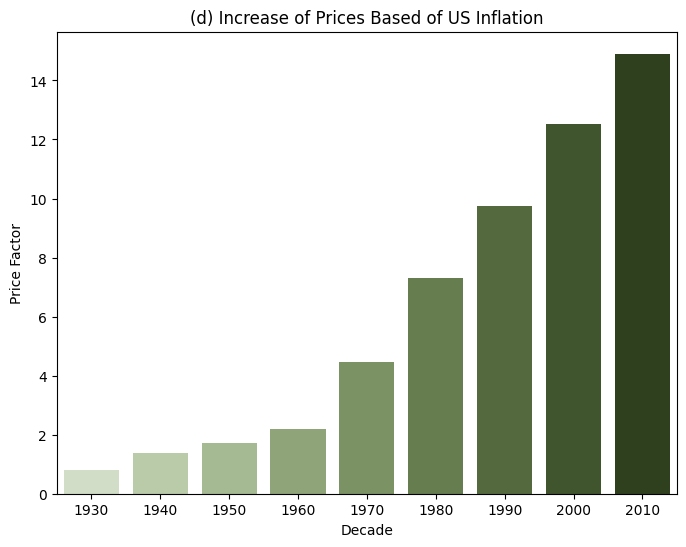

In [153]:
plt.figure(figsize=(8, 6))
sns.barplot(x='decade', y='item_value', data=decade_inflations, palette=DIS_CMAP(10), hue='item_value')

plt.title('(d) Increase of Prices Based of US Inflation')
plt.xlabel('Decade')
plt.ylabel('Price Factor')
plt.legend().remove()

plt.show()

#### Top Production Companies

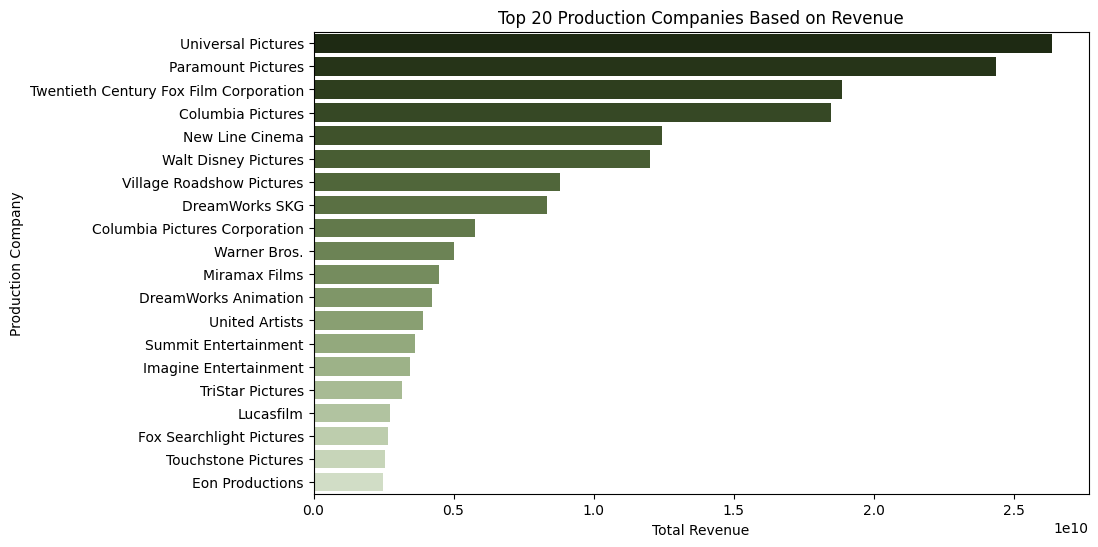

In [32]:
grouped_df = movie_df.groupby('production_company_name')['revenue'].sum().reset_index()

top_20_prod_companies = grouped_df.sort_values(by='revenue', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='revenue', y='production_company_name', data=top_20_prod_companies,
            palette=DIS_CMAP(20, True), order=top_20_prod_companies['production_company_name'])

plt.xlabel('Total Revenue')
plt.ylabel('Production Company')
plt.title('Top 20 Production Companies Based on Revenue')
plt.show()


In [33]:
actor_columns = ['actor_name_1', 'actor_name_2', 'actor_name_3', 'actor_name_4', 'actor_name_5']
all_actors = movie_df[actor_columns].values.flatten()

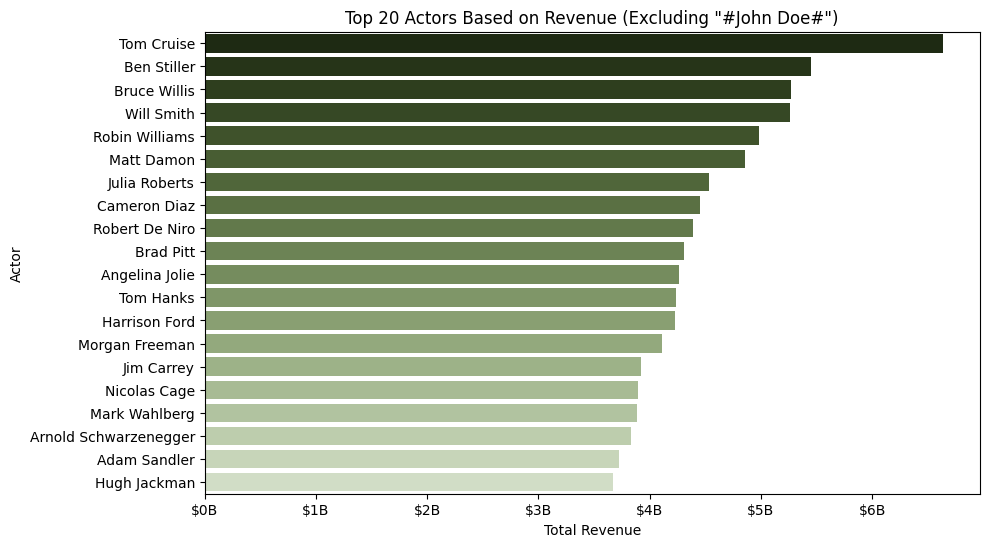

In [34]:
actor_df = pd.DataFrame({'actor_name': all_actors, 'revenue': np.repeat(movie_df['revenue'].values, 5)})

grouped_actor_df = actor_df.groupby('actor_name')['revenue'].sum().reset_index()

grouped_actor_df = grouped_actor_df[grouped_actor_df['actor_name'] != "#John Doe#"]

top_20_actors = grouped_actor_df.sort_values(by='revenue', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='revenue', y='actor_name', data=top_20_actors,
            palette=DIS_CMAP(20, True), order=top_20_actors['actor_name'])

xlabels = ['${:,.0f}B'.format(x) for x in plt.gca().get_xticks()/1e9]
plt.gca().set_xticklabels(xlabels)

plt.xlabel('Total Revenue')
plt.ylabel('Actor')
plt.title('Top 20 Actors Based on Revenue (Excluding "#John Doe#")')
plt.show()


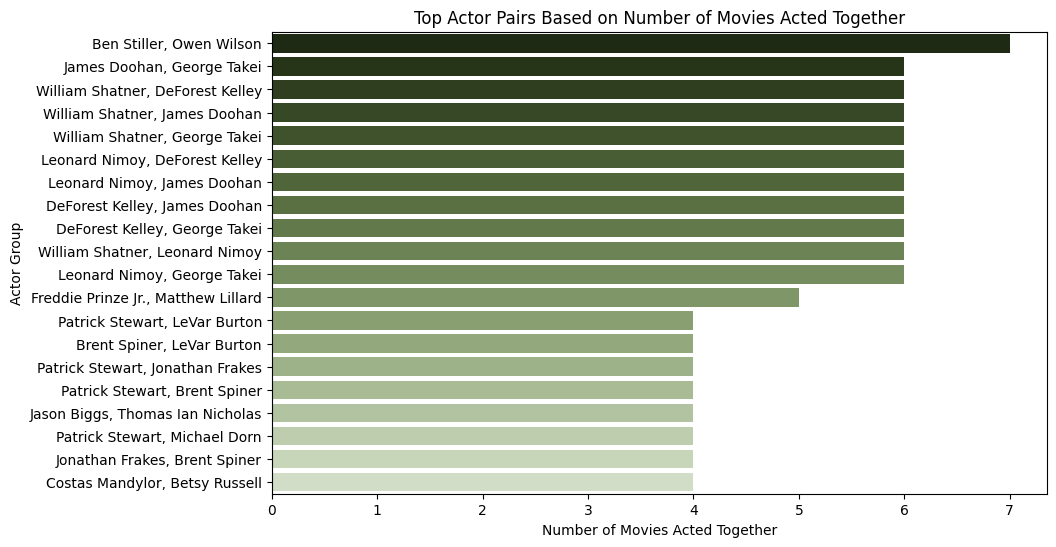

In [154]:
actor_df = pd.DataFrame({
    'actor_name': all_actors, 
    'movie_id': np.repeat(movie_df['ID'].values, 5)
})

actor_df = actor_df[actor_df['actor_name'] != "#John Doe#"]
actor_trios = [list(itertools.combinations(actors, 3)) for actors in grouped_actor_df]

actor_trios = [trio for sublist in actor_trios for trio in sublist]
trio_counts = collections.Counter(actor_trios)

trio_df = pd.DataFrame(trio_counts.items(), columns=['actor_group', 'count'])
trio_df['actor_group'] = trio_df['actor_group'].apply(lambda x: ', '.join(x))

top_20_trios = trio_df.sort_values(by='count', ascending=False).head(20)

actors_in_top_trios = set(itertools.chain.from_iterable(top_20_trios['actor_group'].str.split(', ')))
actor_df = actor_df[~actor_df['actor_name'].isin(actors_in_top_trios)]

actor_pairs = [list(itertools.combinations(actors, 2)) for actors in actor_df.groupby('movie_id')['actor_name'].apply(list)]
actor_pairs = [pair for sublist in actor_pairs for pair in sublist]
pair_counts = collections.Counter(actor_pairs)

pair_df = pd.DataFrame(pair_counts.items(), columns=['actor_group', 'count'])
pair_df['actor_group'] = pair_df['actor_group'].apply(lambda x: ', '.join(x))

top_20_pairs = pair_df.sort_values(by='count', ascending=False).head(20)
top_groups = pd.concat([top_20_trios, top_20_pairs]).sort_values('count', ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='actor_group', data=top_groups,
            palette=DIS_CMAP(20, True), order=top_groups['actor_group'])

plt.xlabel('Number of Movies Acted Together')
plt.ylabel('Actor Group')
plt.title('Top Actor Pairs Based on Number of Movies Acted Together')
plt.show()
